In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
import glob
import pandas as pd

plt.style.use('seaborn-white')
mpl.rcParams.update({'font.size': 16})

## Investigating the effect of S/N on Uncertainty and Lowercut

In [41]:
# Make dictionary of cluster S/N tables

cluster_snr = glob.glob("data/ew_known/equiv_widths/*snr.txt")
snr_dict = {}
for cluster in cluster_snr:
    df = pd.read_csv(cluster, delim_whitespace = True)
    key = cluster.split("/")[-1].split("_")[0]
    snr_dict[key] = df

[-0.022579113355360426, 3.4697321569161494]
R-Squared:  0.172047898913


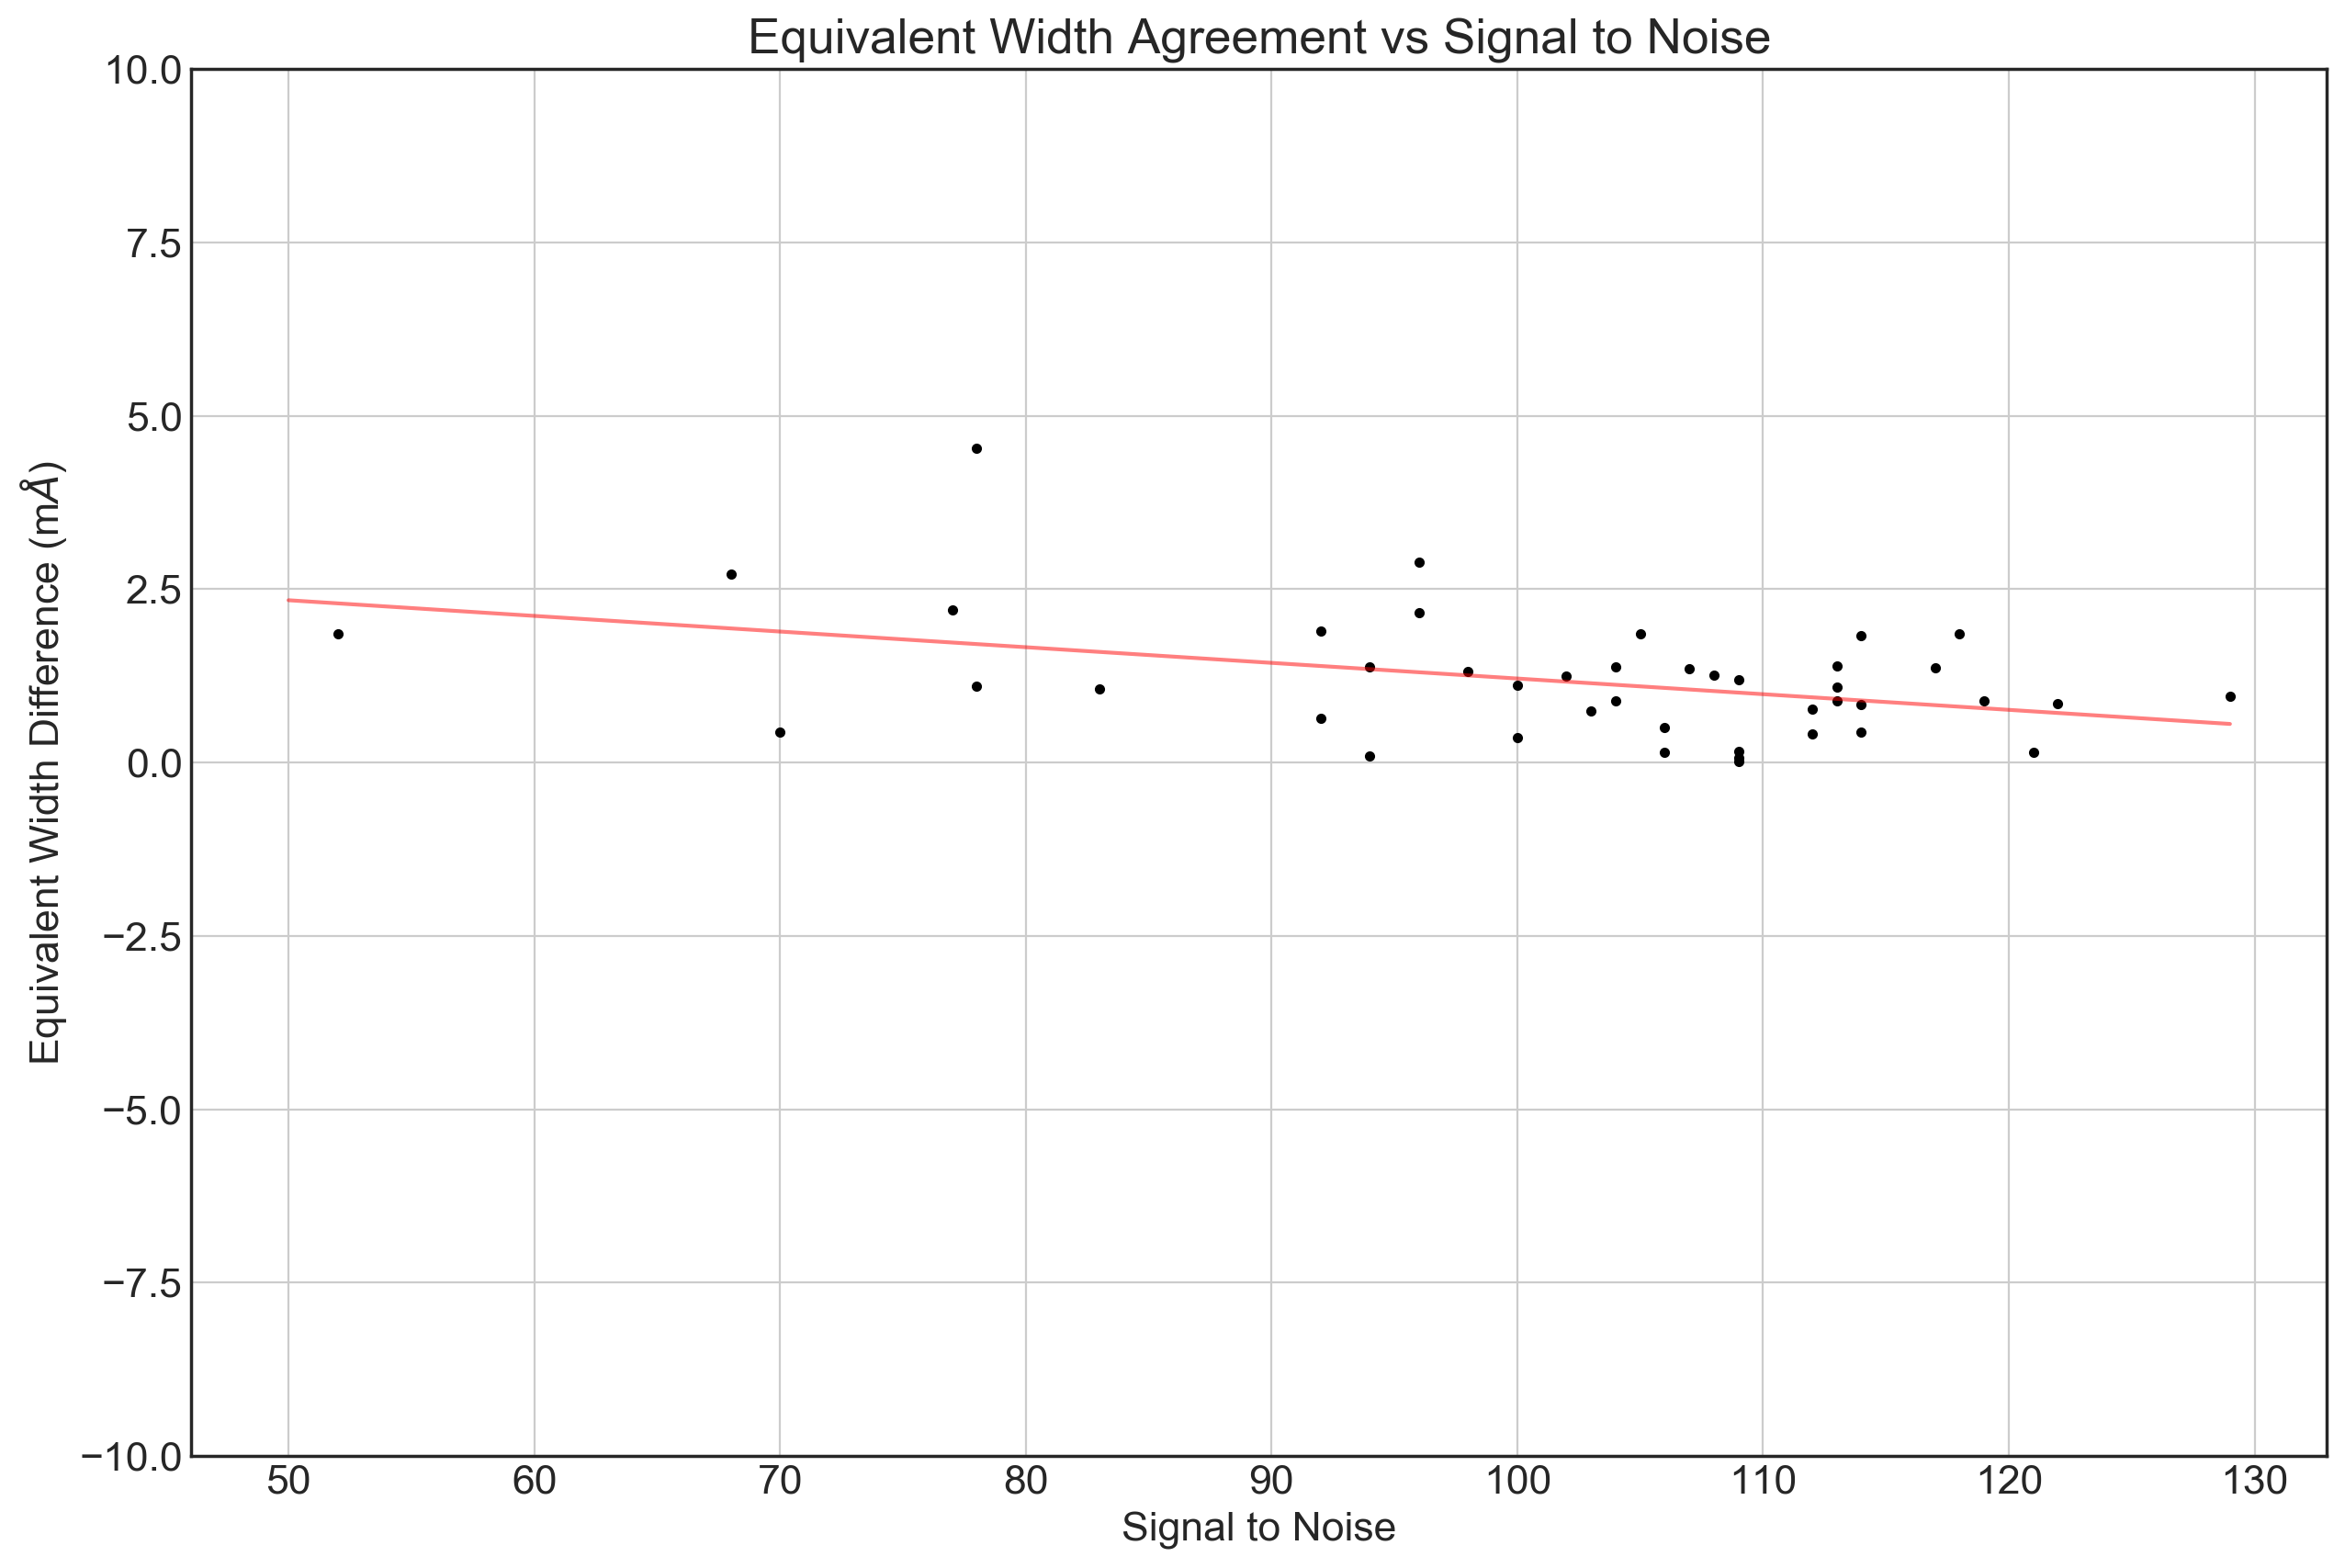

In [108]:
tame_outputs = glob.glob('data/ew_known/equiv_widths/*.ew')
byhand_outputs = ['data/ew_known/tame_inputs/'+output.split('/')[-1] for output in tame_outputs]
output_labels = [output.split('/')[-1].split('.')[0] for output in tame_outputs]


fig = plt.figure(figsize=(15,10))
fig.dpi = 200
plt.grid()
plt.xlabel(r"Signal to Noise")
plt.ylabel("Equivalent Width Difference (m$\AA$)")
plt.title("Equivalent Width Agreement vs Signal to Noise")
plt.ylim(-10,10)

pdiff_avg = []
snr_list = []
for i,byhand_output, tame_output,label in zip(color_idx,byhand_outputs, tame_outputs,output_labels):

    ew_hand = pd.read_csv(byhand_output,delim_whitespace=True,header = None)
    ew_tame = pd.read_csv(tame_output,skiprows=1,delim_whitespace=True,header=None)
    hand_df = ew_hand[[0,4]].sort_values(by=0, ascending=False) # Wavelength and Equivalent Width
    tame_df = ew_tame # Wavelength, Equivalent Width, and linecenter
    label_items = label.split("_")
    cluster, star = label_items[0:2]
    star = star[0:-3]
    
    df = snr_dict[cluster]
    idx = df.index[df['Star'] == int(star)].tolist()
    snr = float(df.loc[idx]['S/N'])
    pdiff = np.array(tame_df[1]) - np.array(hand_df[4])
    
       
    masked_pdiff = [val for val in pdiff if not np.isinf(val) and not (np.isnan(val))]
    pdiff_avg.append(abs(np.mean(masked_pdiff)))
    snr_list.append(snr)

#Attempt a linear fit
coeffs = np.polyfit(snr_list, pdiff_avg, 1)
print(list(coeffs))
p = np.poly1d(coeffs)

yhat = p(snr_list)
ybar = np.sum(pdiff_avg)/len(pdiff_avg)
ssreg = np.sum((yhat-ybar)**2)
sstot = np.sum((pdiff_avg - ybar)**2)
print("R-Squared: ",ssreg / sstot)

x = np.arange(50,130,1)
y = coeffs[0]*x + coeffs[1]
plt.plot(snr_list, pdiff_avg, '.', color='k', label=label)
plt.plot(x, y, '-', color='r', label=label, alpha = 0.5)

